# Inverse-Model
Implementation steps
- [x] implement hessian-vector product
    - gradient convergence according to Taylor-ish test.
    - hessian approximation is close to finite-differences.
- [x] implement projected newton solver
    - still not tested with optimal values along boundary or outside bounds.
- [x] ensure correctness with measurement times not conforming to grid
    - measurements according to piecewise constant. Linear interpolation would require more work.
- [x] verify functioning model with linear interpolation of boundary concentrations
    - Does at least converge to a solution in the 2D case.
- [.] extend to full 3d brain with proper data
    - struggle with getting convergence right. should return after some performance optimization
    - stilll an issue after perfomance optimization. Should look into 
- [x] performance optimization by caching
- [ ] properly implement non-dimensionalization for suitably scaled parameters.
- [ ] run full model for all subjects
- [ ] enable linear interpolation measurements

In [18]:
import numpy as np
import dolfin as df
import tqdm
import pint
import scipy

from dolfin import inner, grad, dot


from glymphopt.cache import CacheObject, cache_fetch
from glymphopt.coefficientvectors import CoefficientVector
from glymphopt.datageneration import BoundaryConcentration
from glymphopt.differentiation import gradient_finite_differences, hessian_finite_differences
from glymphopt.interpolation import LinearDataInterpolator
from glymphopt.io import read_mesh, read_function_data, read_augmented_dti
from glymphopt.measure import measure
from glymphopt.minimize import projected_newton_solver
from glymphopt.operators import (
    mass_matrix, boundary_mass_matrix, stiffness_matrix, matrix_operator, bilinear_operator, matmul, zero_vector
)
from glymphopt.parameters import parameters_2d_default, singlecomp_parameters, get_dimless_parameters, remove_units
from glymphopt.scale import create_reduced_problem
from glymphopt.timestepper import TimeStepper

class Model:
    def __init__(self, V, D=None, g=None):
        D = D or df.Identity(V.mesh().topology().dim())
        
        domain = V.mesh()
        dx = df.Measure("dx", domain)
        ds = df.Measure("ds", domain)
        
        u, v = df.TrialFunction(V), df.TestFunction(V)
        self.M = df.assemble(inner(u, v) * dx)
        self.DK = df.assemble(inner(D * grad(u), grad(v)) * dx)
        self.S = df.assemble(inner(u, v) * ds)
        self.g = g or BoundaryConcentration(V)

def gradient_sensitivities(F, x, **kwargs):
    return np.array([F(x, ei, **kwargs) for ei in np.eye(len(x))])

def measure_interval(n: int, td: np.ndarray, timestepper: TimeStepper):
    bins = np.digitize(td, timestepper.vector(), right=True)
    return list(np.where(n == bins)[0])

class InverseProblem:
    def __init__(self, data_path, coefficientvector, dt=3600, timescale=1.0, g=None, D=None, progress=True):
        self.silent = not progress
        domain = read_mesh(data_path)
        self.td, self.Yd = read_function_data(data_path, domain, "concentration")
        
        t_start = self.td[0]
        dt = dt * timescale
        N = int(np.ceil(np.round((self.td[-1] - t_start) / dt, 12)))
        t_end = N * dt
        self.timestepper = TimeStepper(dt, (t_start, t_end))
        
        
        coefficients = coefficientvector.coefficients
        
        self.V = self.Yd[0].function_space()
        g = g or BoundaryConcentration(self.V, timescale*3600)
        D = D or coefficients["D"] * df.Identity(domain.topology().dim())
        self.model = Model(self.V, g=g, D=D)
        
        
        self.cache = {
            "state": CacheObject(),
            "adjoint": CacheObject(),
            "g": CacheObject(),
            "sensitivity": CacheObject(),
            "operator": CacheObject(),
        }
        
        _M_ = bilinear_operator(self.model.M)
        self.Yd_norms = [_M_(yi.vector(), yi.vector()) for yi in self.Yd]
        self.coefficients = coefficientvector

        
    def F(self, x):
        Y = cache_fetch(self.cache["state"], self.forward, {"x": x}, x=x)
        Ym = measure(self.timestepper, Y, self.td)
        _M_ = bilinear_operator(self.model.M)
        timepoint_errors = [
            _M_(Ym_i.vector() - Yd_i.vector(), Ym_i.vector() - Yd_i.vector()) / norm_i
            for Ym_i, Yd_i, norm_i in zip(Ym[1:], self.Yd[1:], self.Yd_norms[1:])
        ]
        J = 0.5 * sum(timepoint_errors)
        return J
    
    
    def forward(self, x):
        coefficients = self.coefficients.from_vector(x)
        a = coefficients["a"]
        r = coefficients["r"]
        k = coefficients["k"]
        phi = coefficients["phi"]
        
        timestepper = self.timestepper
        dt = timestepper.dt
        timepoints = timestepper.vector()
        Y = [
            df.Function(self.V, name="state") 
            for _ in range(len(timepoints))
        ]
        Y[0].assign(self.Yd[0])
        
        model = self.model
        M = model.M
        L = a * model.DK + r * model.M + k * model.S
        G = cache_fetch(self.cache["g"], self.boundary_vectors, {"phi": phi}, phi=phi)
        solver = cache_fetch(self.cache["operator"], df.LUSolver, {"x": x}, A=M + dt * L)
        Mdot = matrix_operator(M)
        
        N = self.timestepper.num_intervals()
        for n in tqdm.tqdm(range(N), total=N, disable=self.silent):
            solver.solve(Y[n+1].vector(), Mdot(Y[n].vector()) + dt * k * G[n+1])
        return Y
    
    def boundary_vectors(self, phi):
        model = self.model
        timestepper = self.timestepper
        phi = 0.5
        return [ phi * matmul(model.S, model.g(t)) for t in timestepper.vector()]

    
    def gradF(self, x):
        coefficients = self.coefficients.from_vector(x)
        phi = coefficients["phi"]
        dt = self.timestepper.dt
        model = self.model
        Y = cache_fetch(self.cache["state"], self.forward, {"x": x}, x=x)
        Ym = measure(self.timestepper, Y, self.td)
        
        P = cache_fetch(self.cache["adjoint"], self.adjoint, {"x": x}, x=x, Ym=Ym)
        G = cache_fetch(self.cache["g"], self.boundary_vectors, {"phi": phi}, phi=phi)
                                
        _M_ = bilinear_operator(model.M)
        _DK_ = bilinear_operator(model.DK)
        _S_ = bilinear_operator(model.S)
        return dt * sum(
            np.array([
                _DK_(p.vector(), y.vector()),
                _M_(p.vector(), y.vector()),
                _S_(p.vector(), y.vector()) - p.vector().inner(g),
            ])
            for y, p, g in zip(Y[1:], P[:-1], G[1:])
        )
    
    def adjoint(self, x, Ym) -> list[df.Function]:
        coefficients = self.coefficients.from_vector(x)
        a = coefficients["a"]
        r = coefficients["r"]
        k = coefficients["k"]
        
        timestepper = self.timestepper
        dt = timestepper.dt
        timepoints = timestepper.vector()
        
        model = self.model
        M = model.M
        L = a * model.DK + r * model.M + k * model.S
        solver = cache_fetch(self.cache["operator"], df.LUSolver, {"x": x}, A=M + dt * L)
        P = [
            df.Function(self.V, name="adjoint") 
            for _ in range(len(timepoints))
        ]
        Mdot = matrix_operator(M)
        num_intervals = timestepper.num_intervals()
        for n in tqdm.tqdm(range(num_intervals, 0, -1), total=num_intervals, disable=self.silent):
            nj = measure_interval(n, self.td, self.timestepper)
            jump = sum((matmul(M, (Ym[j].vector() - Yd[j].vector()) / self.Yd_norms[j]) for j in nj))

            solver.solve(
                P[n-1].vector(),
                Mdot(P[n].vector()) - jump,
            )
        return P

    def dF(self, x, dx):
        timestepper = self.timestepper
        
        Y = cache_fetch(self.cache["state"], self.forward, {"x": x}, x=x)
        dY = cache_fetch(self.cache["sensitivity"], self.sensitivity, {"x": x, "dx": dx}, x=x, dx=dx, Y=Y)
        Ym = measure(timestepper, Y, self.td)
        dYm = measure(timestepper, dY, self.td)
        _M_ = bilinear_operator(self.model.M)
        return sum([_M_(ym.vector() - yd.vector(), dy.vector()) / norm 
                    for ym, yd, dy, norm in zip(Ym[1:], self.Yd[1:], dYm[1:], self.Yd_norms[1:])])
    
    def hess(self, x):
        return np.array([
            self.hessp(x, ei) for ei in np.eye(len(x))
        ])
    
    def hessp(self, x, dx):
        dt = self.timestepper.dt
        coefficients = self.coefficients.from_vector(x)
        phi = coefficients["phi"]
        
        Y = cache_fetch(self.cache["state"], self.forward, {"x": x}, x=x)
        Ym = measure(self.timestepper, Y, self.td)
        dY = cache_fetch(self.cache["sensitivity"], self.sensitivity, {"x": x, "dx": dx}, x=x, dx=dx, Y=Y)
        dYm = measure(self.timestepper, dY, self.td)
        
        P = cache_fetch(self.cache["adjoint"], self.adjoint, {"x": x}, x=x, Ym=Ym)
        dP = self.second_order_adjoint(x, dx, dYm, P)
        
        model = self.model
        G = cache_fetch(self.cache["g"], self.boundary_vectors, {"phi": phi}, phi=phi)
        _DK_ = bilinear_operator(model.DK)
        _M_ = bilinear_operator(model.M)
        _S_ = bilinear_operator(model.S)
        return dt * sum(
            np.array([
                _DK_(dp.vector(), y.vector()) + _DK_(p.vector(), dy.vector()),
                _M_(dp.vector(), y.vector()) + _M_(p.vector(), dy.vector()),
                _S_(dp.vector(), y.vector()) - dp.vector().inner(g) + _S_(p.vector(), dy.vector()),
            ])
            for y, dy, p, dp, g in zip(Y[1:], dY[1:], P[:-1], dP[:-1], G[1:])
        )


    

    
    def sensitivity(self, x, dx, Y) -> list[df.Function]:
        coefficients = self.coefficients.from_vector(x)
        a = coefficients["a"]
        r = coefficients["r"]
        k = coefficients["k"]
        dD, dr, dk = dx

        timestepper = self.timestepper
        dt = timestepper.dt
        timepoints = timestepper.vector()
        dY = [df.Function(self.V, name="sensitivity") for _ in range(len(timepoints))]

        model = self.model
        M = model.M
        L = a * model.DK + r * model.M + k * model.S
        solver = cache_fetch(self.cache["operator"], df.LUSolver, {"x": x}, A=M + dt * L)
        
        dL = dD * model.DK + dr * model.M + dk * model.S
        Mdot = matrix_operator(M)
        dLdot = matrix_operator(dL)
        Sdot = matrix_operator(model.S)
        G = [matmul(model.S, model.g(t)) for t in timepoints]
        N = self.timestepper.num_intervals()
        for n in tqdm.tqdm(range(N), total=N, disable=self.silent):
            solver.solve(
                dY[n+1].vector(),
                Mdot(dY[n].vector()) - dt * dLdot(Y[n+1].vector()) + dt * dk * G[n+1]
            )
        return dY
    
    def second_order_adjoint(self, x, dx, dYm, P):
        coefficients = self.coefficients.from_vector(x)
        a = coefficients["a"]
        r = coefficients["r"]
        k = coefficients["k"]
        dD, dr, dk = dx

        timestepper = self.timestepper
        dt = timestepper.dt
        timepoints = timestepper.vector()
        
        dP = [df.Function(self.V, name="second-order-adjoint") for _ in range(len(timepoints))]

        model = self.model
        M = model.M
        L = a * model.DK + r * model.M + k * model.S
        dL = dD * model.DK + dr * model.M + dk * model.S
        solver = cache_fetch(self.cache["operator"], df.LUSolver, {"x": x}, A=M + dt * L)

        Mdot = matrix_operator(M)
        dLdot = matrix_operator(dL)
        num_intervals = timestepper.num_intervals()
        for n in tqdm.tqdm(range(num_intervals, 0, -1), total=num_intervals, disable=self.silent):
            nj = measure_interval(n, self.td, self.timestepper)
            jump = sum((matmul(M, dYm[j].vector()) / self.Yd_norms[j] for j in nj))
            solver.solve(
                dP[n - 1].vector(),
                Mdot(dP[n].vector()) - dt * dLdot(P[n-1].vector()) - jump,
            )
        return dP

In [19]:
data_path = "/home/jorgen/gonzo/mri_processed_data/sub-01/modeling/resolution32/data.hdf"
domain = read_mesh(data_path)
td, Yd = read_function_data(data_path, domain, "concentration")
td, Y_bdry = read_function_data(data_path, domain, "boundary_concentration")
coefficients = parameters_2d_default()
coeffconverter = CoefficientVector(coefficients, ("a", "r", "k"))

D = read_augmented_dti(data_path)
D.vector()[:] *= coefficients["rho"]

g = LinearDataInterpolator(td, Y_bdry, valuescale=1.0) # Phi-scaling is in model
coefficients = parameters_2d_default()
coeffconverter = CoefficientVector(coefficients, ("a", "r", "k"))

In [20]:
x0 = coeffconverter.to_vector()
problem = InverseProblem(data_path, coeffconverter, g=g, D=D, progress=True)

In [21]:
problem.F(x0)

100%|███████████████████████████████████████████| 70/70 [00:11<00:00,  6.34it/s]


0.6045958004913192

In [22]:
import pantarei as pr

x_opt = np.array([2.645, 0.0, 2.615])
Y = problem.forward(x_opt)
Ym = measure(problem.timestepper, Y, td)
with df.HDF5File(domain.mpi_comm(), "../results/optimal.hdf", "w") as hdf:
    for tdi, ymi in zip(td, Ym):
        if tdi == 0:
            pr.write_function(hdf, ymi, "total_concentration")
        else:
            pr.write_checkpoint(hdf, ymi, "total_concentration", t=tdi)

with df.XDMFFile(domain.mpi_comm(), "../results/optimal.xdmf") as xdmf:
    for ti, yi in zip(problem.timestepper.vector(), Y):
        xdmf.write(yi, t=ti)

100%|███████████████████████████████████████████| 70/70 [00:11<00:00,  6.30it/s]


In [11]:
x_opt = np.array([2.645, 0.0, 2.615])
Y = problem.forward(x_opt)
Ym = measure(problem.timestepper, Y, td)
with df.HDF5File(domain.mpi_comm(), "../results/optimal.hdf", "w") as hdf:
    for tdi, ymi in zip(td, Ym):
        if tdi == 0:
            pr.write_function(hdf, ymi, "total_concentration")
        else:
            pr.write_checkpoint(hdf, ymi, "total_concentration", t=tdi)

with df.XDMFFile(domain.mpi_comm(), "../results/optimal.xdmf") as xdmf:
    for ti, yi in zip(problem.timestepper.vector(), Y):
        xdmf.write(yi, t=ti)

100%|███████████████████████████████████████████| 70/70 [00:08<00:00,  8.06it/s]


# Convergence tests for gradient and hessian
**TODO:** Something fishy about the Hessian, with convergence order 2 rather than the expected 3. When running for the reduced problems, the issue seem related to the thirds argument, i.e. the conductivity $k$.

In [12]:
from glymphopt.taylor import test_gradient, test_hessian

x1 = 0.95 * coeffconverter.to_vector()
problem.silent = True
test_gradient(problem.F, problem.gradF, x1, p=x1 * 0.1)
test_hessian(problem.F, problem.gradF, problem.hessp, x1, p=x1 * 0.1)
problem.silent = False

Taylor Test for the Gradient:
-----------------------------
       h               Error    Error Ratio
-------------------------------------------
1.00e-01        2.893148e-05              -
5.00e-02        7.249370e-06           3.99
2.50e-02        1.814418e-06           4.00
1.25e-02        4.538646e-07           4.00
6.25e-03        1.134987e-07           4.00
3.13e-03        2.837875e-08           4.00

Taylor Test for the Hessian:
----------------------------
       h               Error    Error Ratio
-------------------------------------------
1.00e-01        1.325335e-07              -
5.00e-02        1.663370e-08           7.97
2.50e-02        2.083433e-09           7.98
1.25e-02        2.606933e-10           7.99
6.25e-03        3.260325e-11           8.00


## Reduced Problem

In [13]:
a_ref = 1.0
r_ref = 1e-6
k_ref = coeffconverter.coefficients["k"]

diffusion_problem = create_reduced_problem(problem, np.array([a_ref, 0.0, k_ref]), [0])
diffusion_bounds = scipy.optimize.Bounds(
    [0.1], [10.0]
)
y0 = np.array([2.8])
diffusion_problem.problem.silent = True
sol_diffusion = scipy.optimize.minimize(
    diffusion_problem.F,
    x0=y0,
    method="L-BFGS-B",
    jac=diffusion_problem.gradF,
    hess=diffusion_problem.hess,
    bounds=diffusion_bounds,
    options={
        "verbose": 3,
    }
)

/tmp/ipykernel_6117/2138169130.py:11: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  sol_diffusion = scipy.optimize.minimize(
/tmp/ipykernel_6117/2138169130.py:11: OptimizeWarning: Unknown solver options: verbose
  sol_diffusion = scipy.optimize.minimize(


In [14]:
results_to_dict

NameError: name 'results_to_dict' is not defined

In [ ]:
sol_diffusion.fun

In [ ]:
a_ref = 1.0
r_ref = 1e-6
k_ref = coeffconverter.coefficients["k"]

diffusion_reaction_problem = create_reduced_problem(problem, np.array([a_ref, r_ref, k_ref]), [0, 1])
diffusion_reaction_bounds = scipy.optimize.Bounds(
    [0.1, 0.0], [10.0, 100.0]
)
y0 = np.array([*sol_diffusion.x, 0.0])
diffusion_reaction_problem.problem.silent = True
sol_diffusion_reaction = scipy.optimize.minimize(
    diffusion_reaction_problem.F,
    x0=y0,
    method="L-BFGS-B",
    jac=diffusion_reaction_problem.gradF,
    hess=diffusion_reaction_problem.hess,
    bounds=diffusion_reaction_bounds,
    options={
        "verbose": 3,
    }
)
# sol_diffusion_reaction = projected_newton_solver(
#     diffusion_reaction_problem.F,
#     diffusion_reaction_problem.gradF,
#     diffusion_reaction_problem.hessp,
#     bounds=diffusion_reaction_bounds,
#     x0=y0,
#     inner_tol=1e-8,
#     tol=1e-8,
#     verbose=True,
# )
sol_diffusion_reaction

In [ ]:
a_ref = 1.0
r_ref = 1e-6
k_ref = coeffconverter.coefficients["k"]

scaled_problem = create_reduced_problem(problem, np.array([a_ref, r_ref, k_ref]), [0, 1, 2])
scaled_bounds = scipy.optimize.Bounds(
    [0.1, 0.0, 0.0], [10.0, 100.0, 1000.0]
)
y0 = np.array([*sol_diffusion_reaction.x, 100.0])
scaled_problem.problem.silent = True
# scaled_solution = projected_newton_solver(
#     scaled_problem.F,
#     scaled_problem.gradF,
#     scaled_problem.hessp,
#     bounds=scaled_bounds,
#     x0=y0,
#     inner_tol=1e-8,
#     tol=1e-8,
#     verbose=True,
# )
scaled_solution = scipy.optimize.minimize(
    scaled_problem.F,
    x0=y0,
    method="L-BFGS-B",
    jac=scaled_problem.gradF,
    hess=scaled_problem.hess,
    bounds=scaled_bounds,
    callback=print_callback
#     options={
#         "verbose": 3,
#         "initial_barrier_parameter": 1e-6,
#     }
)
scaled_solution

In [28]:
def print_callback(intermediate_result):
    print("-"*60)
    print(intermediate_result)

def iterative_subproblem_optimization(problem, coeffconverter):
    print("Solving diffusion only minimization problem.")
    a_ref = 1.0
    r_ref = 1e-6
    k_ref = coeffconverter.coefficients["k"]
    k_ref = 1e0
    diffusion_problem = create_reduced_problem(
        problem, np.array([a_ref, 0.0, k_ref]), [0]
    )
    diffusion_bounds = scipy.optimize.Bounds([0.1], [10.0])
    y0 = np.array([2.8])
    diffusion_problem.problem.silent = True
    sol_diffusion = scipy.optimize.minimize(
        diffusion_problem.F,
        x0=y0,
        method="L-BFGS-B",
        jac=diffusion_problem.gradF,
        hess=diffusion_problem.hess,
        bounds=diffusion_bounds,
        callback=print_callback,
    )

    print("Solving diffusion-reaction reduced minimization problem.")
    a_ref = 1.0
    r_ref = 1e-6
    k_ref = coeffconverter.coefficients["k"]
    k_ref = 1e0
    diffusion_reaction_problem = create_reduced_problem(
        problem, np.array([a_ref, r_ref, k_ref]), [0, 1]
    )
    diffusion_reaction_bounds = scipy.optimize.Bounds([0.1, 0.0], [10.0, 100.0])
    y0 = np.array([*sol_diffusion.x, 0.0])
    diffusion_reaction_problem.problem.silent = True
    sol_diffusion_reaction = scipy.optimize.minimize(
        diffusion_reaction_problem.F,
        x0=y0,
        method="L-BFGS-B",
        jac=diffusion_reaction_problem.gradF,
        hess=diffusion_reaction_problem.hess,
        bounds=diffusion_reaction_bounds,
        callback=print_callback,
    )

    a_ref = 1.0
    r_ref = 1e-6
    k_ref = coeffconverter.coefficients["k"]
    k_ref = 1e0

    scaled_problem = create_reduced_problem(
        problem, np.array([a_ref, r_ref, k_ref]), [0, 1, 2]
    )
    scaled_bounds = scipy.optimize.Bounds([0.1, 0.0, 0.0], [10.0, 100.0, 100.0])
    y0 = np.array([*sol_diffusion_reaction.x, 1.0])
    scaled_problem.problem.silent = True
    scaled_solution = scipy.optimize.minimize(
        scaled_problem.F,
        x0=y0,
        method="L-BFGS-B",
        jac=scaled_problem.gradF,
        bounds=scaled_bounds,
        callback=print_callback,
    )
    print(scaled_solution)
    results_dict = {
        "fun": scaled_solution.fun,
        "x": scaled_problem.transform(scaled_solution.x).tolist(),
        "success": scaled_solution.success,
    }
    return results_dict

In [29]:
iterative_solution = iterative_subproblem_optimization(problem, coeffconverter)

Solving diffusion only minimization problem.


/tmp/ipykernel_6117/1178124190.py:17: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  sol_diffusion = scipy.optimize.minimize(


------------------------------------------------------------
 fun: 0.7120016445990719
   x: [ 2.714e+00]
------------------------------------------------------------
 fun: 0.560771541292737
   x: [ 8.841e-01]
------------------------------------------------------------
 fun: 0.5602503051374628
   x: [ 8.257e-01]
------------------------------------------------------------
 fun: 0.5602495008419851
   x: [ 8.232e-01]
------------------------------------------------------------
 fun: 0.5602494940284514
   x: [ 8.234e-01]
Solving diffusion-reaction reduced minimization problem.


/tmp/ipykernel_6117/1178124190.py:38: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  sol_diffusion_reaction = scipy.optimize.minimize(


------------------------------------------------------------
 fun: 0.5580991056641232
   x: [ 8.234e-01  4.658e-02]
------------------------------------------------------------
 fun: 0.5377191990405499
   x: [ 2.009e+00  3.367e+00]
------------------------------------------------------------
 fun: 0.46278655908180144
   x: [ 1.120e+00  4.884e+00]
------------------------------------------------------------
 fun: 0.46153623622887996
   x: [ 1.003e+00  5.460e+00]
------------------------------------------------------------
 fun: 0.4593435034964057
   x: [ 1.117e+00  6.008e+00]
------------------------------------------------------------
 fun: 0.4589120303963924
   x: [ 1.161e+00  6.481e+00]
------------------------------------------------------------
 fun: 0.45887775897420086
   x: [ 1.173e+00  6.649e+00]
------------------------------------------------------------
 fun: 0.4588771621446295
   x: [ 1.173e+00  6.673e+00]
------------------------------------------------------------
 fun: 0.

In [26]:
iterative_solution

  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: 0.45574469005837376
        x: [ 1.443e+00  6.889e+00  5.367e-01]
      nit: 12
      jac: [-1.682e-07  3.475e-07 -1.079e-06]
     nfev: 14
     njev: 14
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [25]:
iterative_solution

  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: 0.45574469005837376
        x: [ 1.443e+00  6.889e+00  5.367e-01]
      nit: 12
      jac: [-1.682e-07  3.475e-07 -1.079e-06]
     nfev: 14
     njev: 14
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [47]:
sol_scaled

  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: 0.6803903507751387
        x: [ 2.646e+00  0.000e+00  5.000e+02]
      nit: 4
      jac: [ 3.944e-06  1.162e-02 -1.151e-07]
     nfev: 5
     njev: 5
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [107]:
a = coeffconverter.coefficients["a"]
r = 0.0
k = coeffconverter.coefficients["k"]

reduced_problem = create_reduced_problem(problem, np.array([a, r, k]), [0])
reduced_bounds = scipy.optimize.Bounds(
    [0.1 / a],
    [10.0 / a],
)
reduced_problem.problem.silent = True
y0 = np.array([1.0 / a])
sol_x = scipy.optimize.minimize(
    reduced_problem.F,
    x0=y0,
    method="trust-constr",
    jac=reduced_problem.gradF,
    hess=reduced_problem.hess,
    bounds=reduced_bounds,
    options={
        "verbose": 3,
    }
)

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  | penalty  |barrier param|CG stop|
|-------|-------|-------|-------------|----------|----------|----------|----------|-------------|-------|
|   1   |   1   |   0   | +7.5743e-01 | 1.00e+00 | 3.26e-01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   0   |
|   2   |   2   |   1   | +7.1387e-01 | 5.65e+00 | 3.82e-02 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   1   |
|   3   |   3   |   2   | +6.9691e-01 | 5.65e+00 | 3.12e-02 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   1   |
|   4   |   3   |   2   | +6.9691e-01 | 2.83e+01 | 1.15e-02 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   0   |
|   5   |   4   |   3   | +6.9494e-01 | 2.83e+01 | 4.54e-03 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   1   |
|   6   |   4   |   3   | +6.9494e-01 | 1.41e+02 | 8.43e-04 | 0.00e+00 | 1.00e+00 |  4.00e-03   |   0   |
|   7   |   4   |   3   | +6.9494e-01 | 7.07e+02 | 1.02e-04 | 0.00e+00 | 1.00e+00 |  8.00e-04   |   0   |
|   8   |   4   |   3   | +6.9494e-01 | 3.53e+

In [112]:
a * sol_x.x

array([2.8820098])

In [114]:
sol_x = projected_newton_solver(
    reduced_problem.F,
    reduced_problem.gradF,
    reduced_problem.hessp,
    bounds=reduced_bounds,
    x0=y0,
    inner_tol=1e-8,
    verbose=True,
)
sol_x

Iter                              x     Objective    Proj. Grad Norm
----------------------------------------------------------------------
   0                    [2.000e-01]  7.574290e-01       6.341214e-01
   1                    [2.979e-01]  7.175165e-01       2.467230e-01
   2                    [4.050e-01]  7.009106e-01       8.771144e-02
   3                    [5.009e-01]  6.958287e-01       2.575935e-02
   4                    [5.592e-01]  6.949827e-01       4.713737e-03
   5                    [5.754e-01]  6.949431e-01       2.573218e-04
   6                    [5.764e-01]  6.949430e-01       8.853712e-07


  message: Convergence: Projected gradient norm below tolerance.
  success: True
      fun: 0.6949430076393829
        x: [ 5.764e-01]
      nit: 6
     nfev: 7
     njev: 7
     nhev: 12
      jac: [-8.854e-07]
 walltime: 326.730055809021

In [116]:
a * sol_x.x

array([2.88185718])

In [120]:
a = coeffconverter.coefficients["a"]
r = coeffconverter.coefficients["r"]
k = coeffconverter.coefficients["k"]

y0 = np.array([*sol.x, 0.0])

second_reduced_problem = create_reduced_problem(problem, np.array([a, r, k]), [0, 1])
second_reduced_bounds = scipy.optimize.Bounds(
    [0.1 / a, 0.0],
    [10.0 / a, 10.0],
)

sol_x = scipy.optimize.minimize(
    second_reduced_problem.F,
    x0=y0,
    method="trust-constr",
    jac=second_reduced_problem.gradF,
    hess=second_reduced_problem.hess,
    bounds=second_reduced_bounds,
    options={
        "verbose": 3,
    }
)

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  | penalty  |barrier param|CG stop|
|-------|-------|-------|-------------|----------|----------|----------|----------|-------------|-------|
|   1   |   1   |   0   | +7.5522e-01 | 1.00e+00 | 4.61e-02 | 8.82e-01 | 1.00e+00 |  1.00e-01   |   0   |
|   2   |   2   |   1   | +7.5844e-01 | 7.00e+00 | 3.93e-02 | 1.33e-01 | 1.00e+00 |  1.00e-01   |   2   |
|   3   |   3   |   2   | +8.3102e-01 | 1.42e+01 | 4.98e-02 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |
|   4   |   4   |   3   | +7.9926e-01 | 1.42e+01 | 5.50e-03 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |
|   5   |   4   |   3   | +7.9926e-01 | 7.11e+01 | 3.31e-02 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   0   |
|   6   |   5   |   5   | +7.9926e-01 | 7.11e+00 | 3.31e-02 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   1   |
|   7   |   6   |   7   | +7.9926e-01 | 7.11e-01 | 3.31e-02 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |
|   8   |   7   |   8   | +7.6097e-01 | 4.97e+

In [122]:
second_reduced_problem.transform(sol_x.x)

array([2.88217026e+00, 4.91535939e-10, 1.70000000e-03])

In [121]:
sol_x

           message: `gtol` termination condition is satisfied.
           success: True
            status: 1
               fun: 0.6949494027395096
                 x: [ 5.764e-01  5.401e-05]
               nit: 24
              nfev: 18
              njev: 12
              nhev: 12
          cg_niter: 23
      cg_stop_cond: 1
              grad: [ 6.984e-06  1.184e-01]
   lagrangian_grad: [-4.582e-09 -2.834e-13]
            constr: [array([ 5.764e-01,  5.401e-05])]
               jac: [<Compressed Sparse Row sparse matrix of dtype 'float64'
                    	with 2 stored elements and shape (2, 2)>]
       constr_nfev: [0]
       constr_njev: [0]
       constr_nhev: [0]
                 v: [array([-6.989e-06, -1.184e-01])]
            method: tr_interior_point
        optimality: 4.582062224375925e-09
  constr_violation: 0.0
    execution_time: 702.6188917160034
         tr_radius: 551.9830074842263
    constr_penalty: 1.0
 barrier_parameter: 6.400000000000003e-06
 barrier_toleran

In [129]:
y0 / 5

array([0.57637144, 0.        ])

In [130]:
y0

array([2.88185718, 0.        ])

In [126]:
second_reduced_problem.S

array([[5.0e+00, 0.0e+00],
       [0.0e+00, 9.1e-06],
       [0.0e+00, 0.0e+00]])

In [133]:
sol_x = projected_newton_solver(
    second_reduced_problem.F,
    second_reduced_problem.gradF,
    second_reduced_problem.hessp,
    bounds=second_reduced_bounds,
    x0=np.array([y0[0] / 5, 0.1]),
    inner_tol=1e-8,
    verbose=True,
)
sol_x

Iter                              x     Objective    Proj. Grad Norm
----------------------------------------------------------------------
   0          [5.764e-01 1.000e-01]  7.069760e-01       1.227917e-01
Falling back to projected gradient.
   1          [5.916e-01 0.000e+00]  6.949720e-01       3.740036e-03
   2          [5.755e-01 0.000e+00]  6.949431e-01       2.171389e-04
   3          [5.764e-01 0.000e+00]  6.949430e-01       6.313251e-07


  message: Convergence: Projected gradient norm below tolerance.
  success: True
      fun: 0.6949430076386374
        x: [ 5.764e-01  0.000e+00]
      nit: 3
     nfev: 4
     njev: 4
     nhev: 7
      jac: [-6.313e-07  1.184e-01]
 walltime: 204.84353041648865

In [ ]:
reduced_bounds = scipy.optimize.Bounds([0.5], [10])
sol_x = projected_newton_solver(
    reduced_problem.F,
    reduced_problem.gradF,
    reduced_problem.hessp,
    bounds=reduced_bounds,
    x0=y0,
    inner_tol=1e-8,
    verbose=True,
)
sol_x

In [ ]:
from glymphopt.minimize import custom_trust_region_solver

In [ ]:
import time as pytime
import scipy.optimize
bounds = scipy.optimize.Bounds([1e-1, 0, 0], [np.inf, np.inf, np.inf])
x0 = [3.0, 1e-6, 1e-3] # 3D 
# x0 = [8.0, 1e-4, 2]  # 2D test examplea/
sol_x = custom_trust_region_solver(
    problem.F,
    problem.gradF,
    problem.hessp,
    bounds=bounds,
    x0=np.linalg.inv(problem.scale_matrix).dot(x0),
)
sol_x

In [ ]:
import time as pytime
import scipy.optimize
bounds = scipy.optimize.Bounds([1e-1, 0, 0], [np.inf, np.inf, np.inf])
x0 = [3.0, 1e-6, 1e-3] # 3D 
# x0 = [8.0, 1e-4, 2]  # 2D test examplea/
sol_x = projected_newton_solver(
    problem.F,
    problem.gradF,
    problem.hessp,
    bounds=bounds,
    x0=np.linalg.inv(problem.scale_matrix).dot(x0),
    inner_tol=1e-8,
    verbose=True,
)
sol_x

0.1
0.251188643150958
0.6309573444801934
1.584893192461114
3.981071705534973
10.0


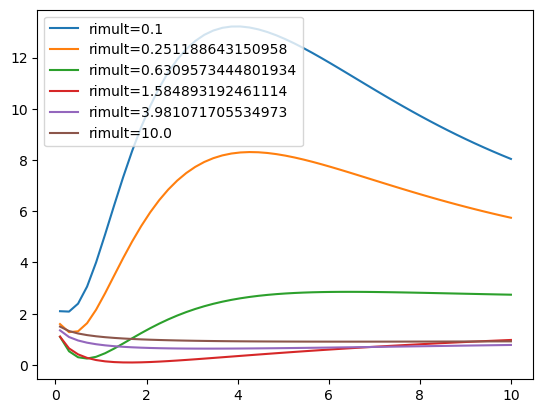

In [169]:
x0 = coeffconverter.to_vector()
x1 = 0.9 * x0
S = np.array([[x1[0], 0, 0]]).T
offset = np.array([0, *x1[1:]])

reduced_problem = ReducedProblem(problem, S, offset)
J = []
for ri_mult in np.logspace(-1, 1, 6):
    print(ri_mult)
    J = []
    offset = np.array([0, ri_mult * x1[1], x1[2]])
    reduced_problem = ReducedProblem(problem, S, offset)
    for yi in np.linspace(0.1, 10, 51):
        J.append(reduced_problem.F(np.array([yi])))
    plt.plot(np.linspace(0.1, 10, 51), J, label=f"rimult={ri_mult}")
    
plt.legend()
plt.show()

0.1
0.251188643150958
0.6309573444801934
1.584893192461114
3.981071705534973
10.0


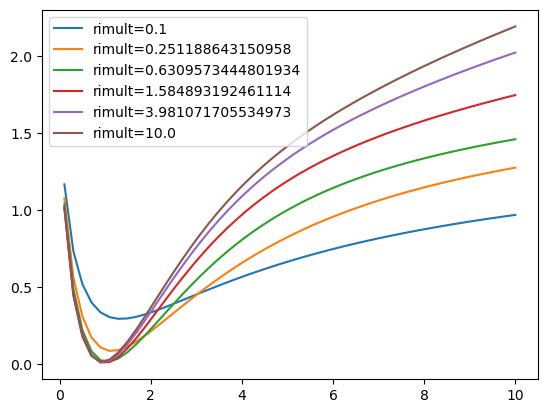

In [168]:
x0 = coeffconverter.to_vector()
x1 = 0.9 * x0
S = np.array([[x1[0], 0, 0]]).T

reduced_problem = ReducedProblem(problem, S, offset)
J = []
for mult in np.logspace(-1, 1, 6):
    print(mult)
    J = []
    offset = np.array([0, x1[1], mult * x1[2]])
    reduced_problem = ReducedProblem(problem, S, offset)
    for yi in np.linspace(0.1, 10, 51):
        J.append(reduced_problem.F(np.array([yi])))
    plt.plot(np.linspace(0.1, 10, 51), J, label=f"rimult={mult}")
    
plt.legend()
plt.show()

In [135]:
y0 = np.array([.0])
reduced_problem.F(y0)

1.6945225963867596

In [136]:
reduced_problem.gradF(y0)

array([-24.5720376])

In [142]:
x1 

array([4.50e+00, 8.19e-06, 1.53e-03])

In [143]:
x1

array([4.50e+00, 8.19e-06, 1.53e-03])

In [167]:
problem.silent = True

x0 = 0.9 * coeffconverter.to_vector()

S = np.array([[x0[0], 0, 0]]).T
offset = np.array([0.0, 0.0, x0[3]])
y0 = np.array([1.0])

IndexError: index 3 is out of bounds for axis 0 with size 3

In [163]:
reduced_problem = ReducedProblem(problem, S, offset)
reduced_bounds = scipy.optimize.Bounds([0.5], [10])
sol_x = projected_newton_solver(
    reduced_problem.F,
    reduced_problem.gradF,
    reduced_problem.hessp,
    bounds=reduced_bounds,
    x0=y0,
    inner_tol=1e-8,
    verbose=True,
)
sol_x

Iter                              x     Objective    Proj. Grad Norm
----------------------------------------------------------------------
   0                    [1.000e+00]  8.927392e-03       4.272802e-03
   1                    [1.004e+00]  8.918123e-03       2.118828e-05
   2                    [1.004e+00]  8.918123e-03       5.280585e-10


  message: Convergence: Projected gradient norm below tolerance.
  success: True
      fun: 0.008918122792401527
        x: [ 1.004e+00]
      nit: 2
     nfev: 3
     njev: 3
     nhev: 4
      jac: [-5.281e-10]
 walltime: 6.20486855506897

In [241]:
color = np.array([d["min"] for d in minimizers.values()])
color

array([2.33209304, 2.30780983, 2.26870646, 2.20720518, 2.09934814,
       1.74001221, 1.22236779, 0.62483362, 0.14773578, 0.0105874 ])

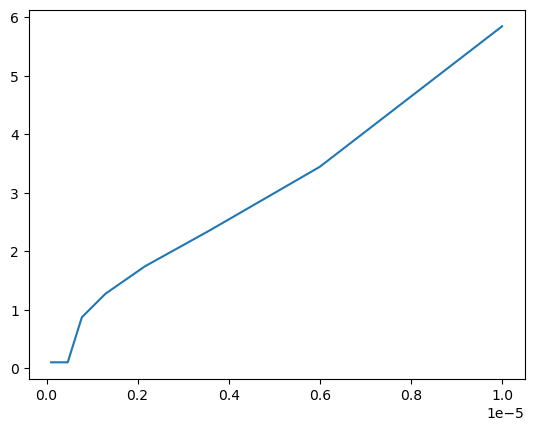

In [245]:
plt.plot(
    [d["r"] for d in minimizers.values()],
    [d["D_best"] for d in minimizers.values()],
)

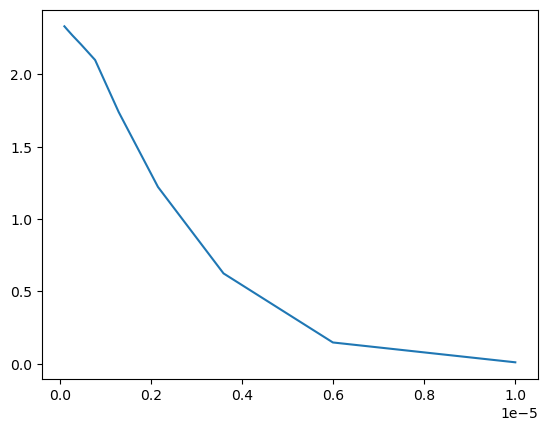

In [247]:
plt.plot(
    [d["r"] for d in minimizers.values()],
    [d["min"] for d in minimizers.values()],
)

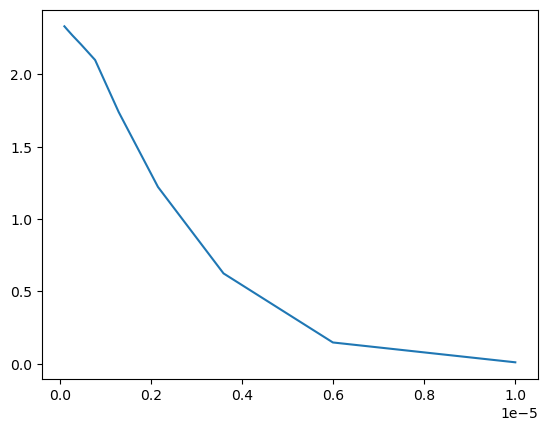

In [248]:
plt.plot(
    [d["r"] for d in minimizers.values()],
    [d["min"] for d in minimizers.values()],
)

In [244]:
minimizers

{0: {'D_best': np.float64(0.1),
  'r': np.float64(1e-07),
  'min': 2.332093036578885},
 1: {'D_best': np.float64(0.1),
  'r': np.float64(1.6681005372000585e-07),
  'min': 2.3078098310737962},
 2: {'D_best': np.float64(0.1),
  'r': np.float64(2.7825594022071243e-07),
  'min': 2.2687064608634175},
 3: {'D_best': np.float64(0.1),
  'r': np.float64(4.6415888336127784e-07),
  'min': 2.207205175838655},
 4: {'D_best': np.float64(0.8699001417196817),
  'r': np.float64(7.74263682681127e-07),
  'min': 2.099348138889411},
 5: {'D_best': np.float64(1.271759701063249),
  'r': np.float64(1.291549665014884e-06),
  'min': 1.7400122132598814},
 6: {'D_best': np.float64(1.7391686828869632),
  'r': np.float64(2.154434690031883e-06),
  'min': 1.2223677863733828},
 7: {'D_best': np.float64(2.361131201154651),
  'r': np.float64(3.5938136638046257e-06),
  'min': 0.624833617249247},
 8: {'D_best': np.float64(3.4415460455922076),
  'r': np.float64(5.994842503189409e-06),
  'min': 0.14773578433171877},
 9: {'D

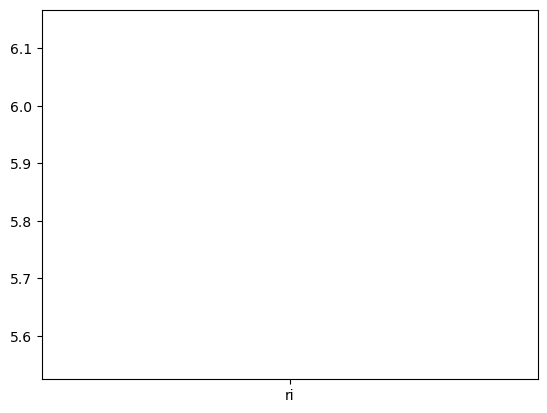

In [227]:
plt.plot(best_diffusion.keys(), best_diffusion.values())

## Scaled Gradient Descent

In [207]:
from glymphopt.minimize import projected_gradient_descent

In [208]:
S = np.array([
    [1.0, 0.0, 0.0],
    [0.0, 1e-5,0.0],
    [0.0, 0.0, 1e-3]
])
offset = np.zeros_like(x0)
y0 = np.array([1.0, 0., 1e-2])

In [209]:
reduced_problem = ReducedProblem(problem, S, x0)
reduced_bounds = scipy.optimize.Bounds([0.1, 0.0, 0.1], [10, 100, 100])

In [210]:
projected_gradient_descent(
    reduced_problem.F,
    reduced_problem.gradF,
    (reduced_bounds.lb, reduced_bounds.ub),
    x0=y0,
)

[ 0.30914226 10.3548905   0.1       ] [ 1.38171548e+00 -2.07097810e+01  7.23360050e-04] 0.5 20.755822491369283
[ 0.3518523  10.34544857  0.10036907] [-0.08542008  0.01888387 -0.00073814] 0.5 0.08748562582212092
[ 0.39381156 10.33596255  0.10074086] [-0.08391853  0.01897204 -0.00074358] 0.5 0.08603958931708335
[ 0.4350547  10.326434    0.10111522] [-0.08248626  0.01905711 -0.00074871] 0.5 0.08466237332960577
[ 0.47561373 10.31686434  0.10149199] [-0.08111806  0.01913931 -0.00075355] 0.5 0.08334879252278626
[ 0.51551836 10.30725492  0.10187104] [-0.07980926  0.01921885 -0.00075811] 0.5 0.08209419420979369
[ 0.55479618 10.29760695  0.10225225] [-0.07855564  0.01929592 -0.00076241] 0.5 0.08089438988098054
[ 0.59347288 10.28792161  0.10263548] [-0.0773534   0.0193707  -0.00076646] 0.5 0.07974559720896424
[ 0.63157243 10.27819994  0.10302062] [-0.07619911  0.01944332 -0.00077029] 0.5 0.07864439068541425
[ 0.66911724 10.26844297  0.10340757] [-0.07508963  0.01951395 -0.0007739 ] 0.5 0.0775876

KeyboardInterrupt: 